## 异常检测——高维数据的异常检测
本节内容理解不深，网上找到的资料也比较少。就分别运行feature bagging和isolation forests的例子，进行了调参。

## 1、原理  
Feature Bagging:  
    基本思想与bagging相似，只是对象是feature。feature bagging属于集成方法的一种。集成方法的设计有以下两个主要步骤： 
1.选择基检测器。这些基本检测器可以彼此完全不同，或不同的参数设置，或使用不同采样的子数据集。Feature bagging常用lof算法为基算法。
2.分数标准化和组合方法：不同检测器可能会在不同的尺度上产生分数。例如，平均k近邻检测器会输出原始距离分数，而LOF算法会输出归一化值。另外，尽管一般情况是输出较大的异常值分数，但有些检测器会输出较小的异常值分数。因此，需要将来自各种检测器的分数转换成可以有意义的组合的归一化值。分数标准化之后，还要选择一个组合函数将不同基本检测器的得分进行组合，最常见的选择包括平均和最大化组合函数。  

Isolation Forests:  
    孤立森林（Isolation Forest）算法是周志华教授等人于2008年提出的异常检测算法，是机器学习中少见的专门针对异常检测设计的算法之一，方法因为该算法时间效率高，能有效处理高维数据和海量数据，无须标注样本，在工业界应用广泛。 
    孤立森林属于非参数和无监督的算法，既不需要定义数学模型也不需要训练数据有标签。孤立森林查找孤立点的策略非常高效。假设我们用一个随机超平面来切割数据空间，切一次可以生成两个子空间。然后我们继续用随机超平面来切割每个子空间并循环，直到每个子空间只有一个数据点为止。直观上来讲，那些具有高密度的簇需要被切很多次才会将其分离，而那些低密度的点很快就被单独分配到一个子空间了。孤立森林认为这些很快被孤立的点就是异常点。  
    
   对于两种模型，就检测效果来说，Isolation Forest表现较稳定，但它更适合于中大数据量和高维空间。Feature Bagging的运算开销很高，这个是可以理解的，因为它训练了10个LOF作为子模型，可以观察一下它的速度差不多比LOF慢十倍。但值得注意的是Feature Bagging其实是一个模型框架，子模型可以用任何模型，比如HBOS等，因此效果可以提升。

## 2、Feature Bagging Example 


In [14]:
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.feature_bagging import FeatureBagging
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    clf = FeatureBagging(check_estimator=False)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)

用200个点的训练集和100个点的测试集，example程序运行结果如下：  
On Training Data:  
FeatureBagging ROC:1.0, precision @ rank n:1.0  
On Test Data:  
FeatureBagging ROC:1.0, precision @ rank n:1.0  

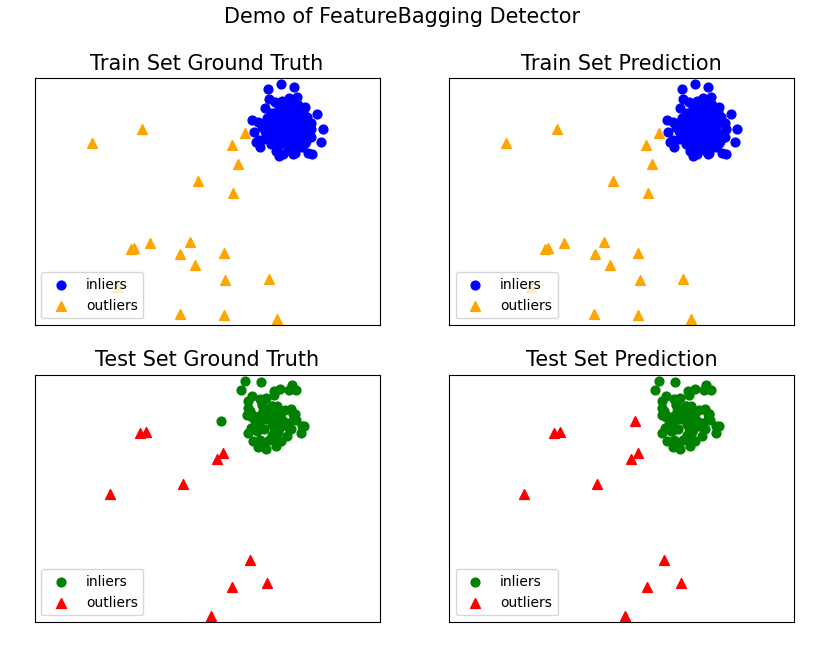


看起来运行效果很好。Feature Bagging 默认是用10个LOF作为子模型。  
调节子模型个数为2个，结果如下
On Training Data:  
FeatureBagging ROC:0.9997, precision @ rank n:0.95  
On Test Data:  
FeatureBagging ROC:1.0, precision @ rank n:1.0  

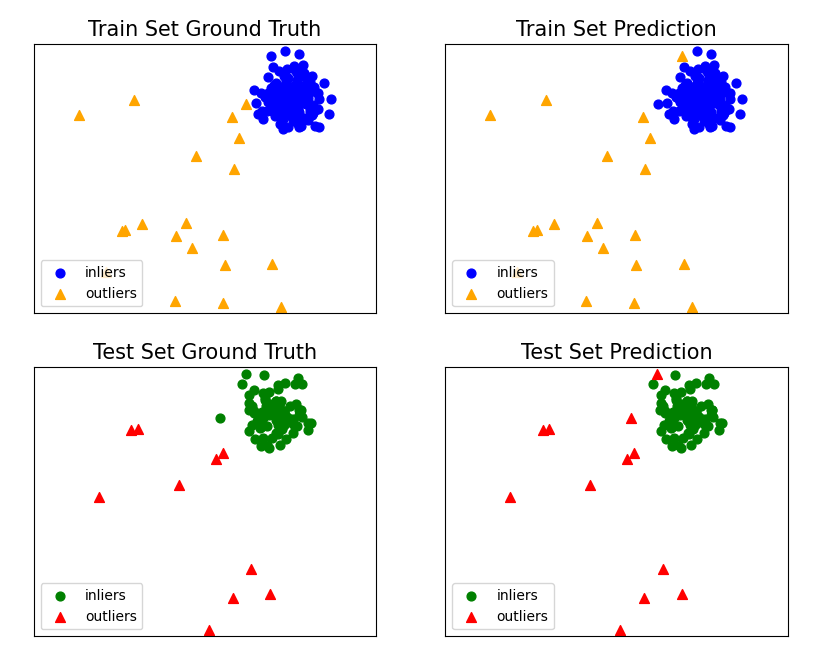
可见子模型的个数，在这个例子中影响不大

从上面可以得出结论，在小数量级上，Feature Bagging还是表现很好。那么，提升数据量会怎么样呢？  
用1000个点的训练集和200个点的测试集， 运行结果如下：  
On Training Data:  
FeatureBagging ROC:0.5966, precision @ rank n:0.23  
On Test Data:  
FeatureBagging ROC:0.6025, precision @ rank n:0.2  

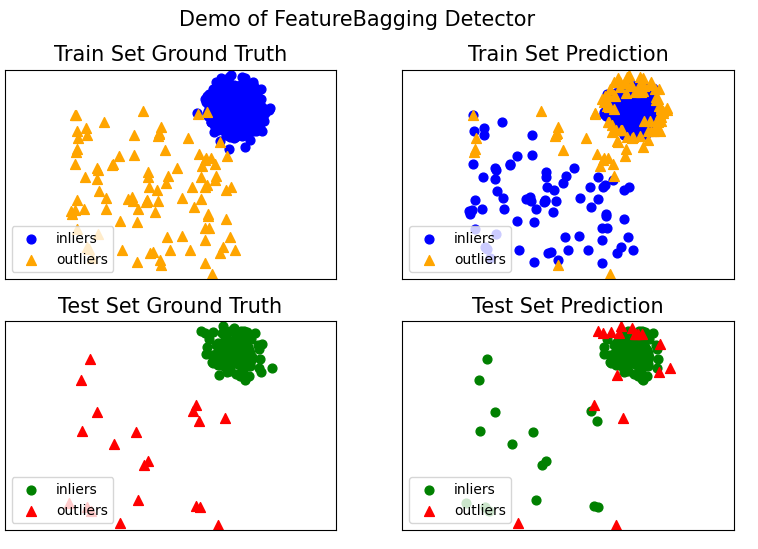

    可以看出，运行效果很差，有大量的正常点被判为异常，同时大量的异常点被判为正常。由于Feature Bagging使用了10个LOF子模型。看资料，LOF适用于中等高维度数据集，估计是数据集维度低（只有2维），在大数据量情况下表现较差。有待验证。  
    考虑换用HBOS子模型的效果。

In [ ]:
clf1 = HBOS(5, 0.1)
#替换下面的代码
clf = FeatureBagging(base_estimator=clf1, n_estimators=2, check_estimator=False)

只替换上面的代码，得到应用HBOS子模型的运行效果如下：  
On Training Data:  
FeatureBagging ROC:0.9887, precision @ rank n:1.0  
On Test Data:  
FeatureBagging ROC:1.0, precision @ rank n:1.0  

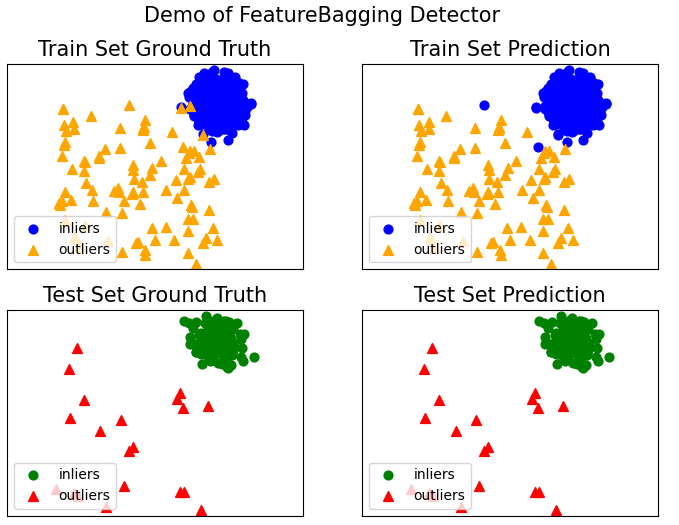  

可以证明， 在数据量较大的情况下， 可换用HBOS子模型，提升FeatureBagging的检测效果。

## 2、Isolation Forest Example 

In [ ]:
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train IForest detector
    clf_name = 'IForest'
    clf = IForest()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)

程序运行结果如下：  
On Training Data:  
FeatureBagging ROC:0.9997, precision @ rank n:0.95  
On Test Data:  
FeatureBagging ROC:1.0, precision @ rank n:1.0  

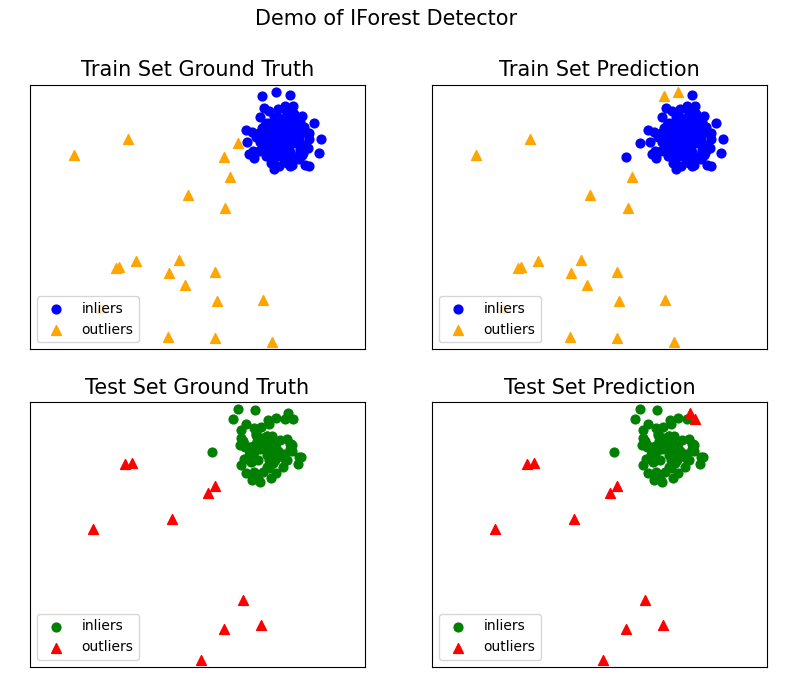  

增加数据量到训练集1000个点，测试集200个点，重新运行：  

On Training Data:
IForest ROC:0.9964, precision @ rank n:0.91
On Test Data:
IForest ROC:0.9994, precision @ rank n:0.95

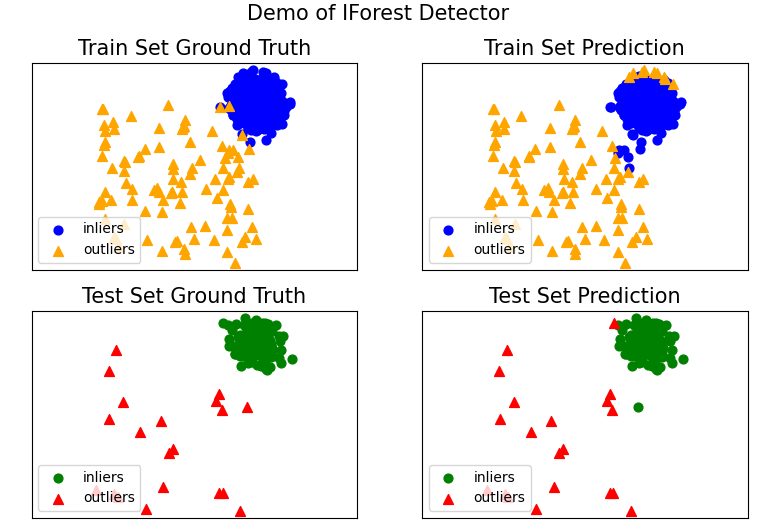  

结论：  
   Isolation Forest表现较稳定，即适合于小数据量，也适合于大数据量。Feature Bagging当运行在低维大数据量时，效果较差，可以换用HBOS子模型。

思考题：
1、Feature Bagging为什么可以降低方差？  
   Feature Bagging采用多个分类器集体表决，就算其中一个分类器偏差较大，整体不会受其影响，偏差较小。然后，集体表决意味着模型泛化能力较强，其分类能力相对于其中的每一个单一分类器时稳定的，所以相当于降低了方差。
